In [1]:
import os
print(os.environ['LD_LIBRARY_PATH'])
os.environ['LD_LIBRARY_PATH']="/mnt/sw/nix/store/zi2wc26znf75csf5hhz77p0d2bbz53ih-cuda-11.8.0/lib64:$LD_LIBRARY_PATH"

import sys

import numpy as np
import time
import healpy as hp
import matplotlib.pyplot as plt
import cupy as cp
import lenspyx
import pysht
from pysht import get_geom
import delensalot
from delensalot import utils
from delensalot.sims.sims_lib import Xunl, Xsky

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

lmax, mmax, phi_lmax = 1023, 1023, 1023

ll = np.arange(0,lmax)

# Tunl_random = np.array([np.random.randn(hp.Alm.getsize(lmax)) + 1j*np.random.randn(hp.Alm.getsize(lmax))], dtype=np.complex128)[0]*1e-6
# dlm_random = np.array([np.random.randn(hp.Alm.getsize(phi_lmax)) + 1j*np.random.randn(hp.Alm.getsize(phi_lmax))], dtype=np.complex128)[0]*1e-6
# print(dlm_random.shape, Tunl_random.shape)
# Tunl = Tunl_random
# dlm = dlm_random


solver = 'shtns'
geominfo = ('gl',{'lmax':lmax})
lenjob_geominfo = ('gl',{'lmax':phi_lmax}) #('thingauss', {'lmax':phi_lmax, 'smax':3})

synunl = Xunl(lmax=lmax, geominfo=geominfo, phi_lmax=phi_lmax)
synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo, lenjob_geominfo=lenjob_geominfo, epsilon=1e-10)

philm = synunl.get_sim_phi(0, space='alm')

Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
Tunlmap = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
Tskyalm = synsky.get_sim_sky(0, spin=0, space='alm', field='temperature')

Tsky2 = synsky.unl2len(Tunl, philm, spin=0, epsilon=1e-10)

lldlm = np.arange(0, phi_lmax+1)
dlm = hp.almxfl(philm, np.sqrt(lldlm*(lldlm+1)))

/mnt/sw/nix/store/pmwk60bp5k4qr8vsg411p7vzhr502d83-openblas-0.3.23/lib:/cm/shared/apps/slurm/current/lib64
[SHTns 3.6.6] built Apr  8 2024, 07:59:49, id: v3.6.6-10-g3986338*,avx512,ishioka,openmp,cuda
Could not import skcuda.fft
mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map
INFO:: 04-11 17:33:20:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-11 17:33:20:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
INFO:: 04-11 17:33:20:: delensalot.sims.sims_lib.__init__ - sht_solver not given, defaulting to ducc
INFO:: 04-11 17:33:20:: delensalot.sims.sims_lib.__init__ - sht_backend not given, defaulting to CPU
1023
CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
    spin: ()
    lmax: ()
    mmax: ()
    nthreads: ()
  Output shape: [(2097152,)], types: [<class 'numpy.ndarray'>]
1023
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
shapes:  (1024,) (1024,) (1024,) (1024,)

In [2]:
"""
gclm2lenmap
"""
kwargs = {
    'geominfo': geominfo,
    'nthreads': 10,
    'epsilon': 1e-10,
    'verbosity': 1,
    'single_prec': False,
    'planned': False,
}
    
deflection_kwargs = {
    'dlm': dlm,
    'mmax_dlm': phi_lmax,
    'epsilon': 1e-10,
    'verbosity': 1,
    'single_prec': False,
    'geominfo': lenjob_geominfo,
    'nthreads': 10,
}

defres = {}
for backend in ['CPU', "GPU"]:
    if backend == 'GPU':
        solvers = ['cufinufft']
        sht_solver = 'shtns' # 'shtns'
    elif backend == 'CPU':
        solvers = ['duccnufft'] # duccnufft lenspyx
        sht_solver = 'ducc' # 'shtns'

    for solver in solvers:
        for mode in ['nuFFT']:
            print("Testing solver={} backend={} mode={}...".format(solver, backend, mode))
            t = pysht.get_transformer(solver, mode, backend)
            t = t(sht_solver, **kwargs, deflection_kwargs=deflection_kwargs)

            print("\n----Testing function gclm2lenmap...----")
            if backend == 'GPU':
                defres.update({
                    backend: t.gclm2lenmap_cupy(
                        Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, mode=2)})
                
            else:
                if solver == 'lenspyx':
                    defres.update({
                        backend: t.gclm2lenmap(
                            Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, mode=2)})
                else:
                    defres.update({
                        backend: t.gclm2lenmap(
                            Tunl.copy(), dlm=dlm, lmax=lmax, mmax=lmax, spin=0, nthreads=10, mode=2)})

Testing solver=duccnufft backend=CPU mode=nuFFT...
deflection std is 2.58e+00 amin

----Testing function gclm2lenmap...----
Running in debug mode
- - - - - - - - - - - - - - - Timing setup: 0.151 seconds- - - - - - - - - - - - - - - 

CPU_DUCCnufft_transformer._synthesis
  Input shapes:
    self: ()
    gclm: (1, 524800)
    out: ()
  Output shape: [(1, 1032, 2048)], types: [<class 'numpy.ndarray'>]
- - - - - - - - - - - - - - - Timing synthesis: 0.019 seconds- - - - - - - - - - - - - - - 

CPU_SHT_DUCC_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
  Output shape: [(2097152,), (2097152,)], types: [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
 iam here 1023 1023 1023
- - - - - - - - - - - - - - - Timing dlm2pointing: 0.059 seconds- - - - - - - - - - - - - - - 

CPU_DUCCnufft_transformer.dlm2pointing
  Input shapes:
    self: ()
    pointing_theta: ()
    pointing_phi: ()
  Output shape: [(2097152,), (2097152,)], types: [<class 'numpy.ndarray'>, <class 'nump

/mnt/home/sbelkner/git/pySHT/pysht/deflection/GPU_nufft_transformer.py:161: RuntimeWarning: divide by zero encountered in divide
  scaled = hp.almxfl(dlm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))))


deflection._pointing
  Input shapes:
    self: ()
    spin1_theta: (2097152,)
    spin1_phi: (2097152,)
    cpt: (1024,)
    cpphi0: (1024,)
    cpnph: (1024,)
    cpofs: (1024,)
    pointing_theta: (2097152,)
    pointing_phi: (2097152,)
  Output shape: [(2097152,), (2097152,)], types: [<class 'cupy.ndarray'>, <class 'cupy.ndarray'>]
- - - - - - - - - - - - - - - Timing pointing: 0.202 seconds- - - - - - - - - - - - - - - 

- - - - - - - - - - - - - - - Timing dlm2pointing: 0.000 seconds- - - - - - - - - - - - - - - 

pointing_theta: [2.04074499e-03 2.04304148e-03 2.04534394e-03 ... 3.14027702e+00
 3.14027443e+00 3.14027182e+00]
pointing_phi: [0.29085662 0.29462061 0.29837986 ... 0.33543611 0.34054585 0.34564245]
GPU_cufinufft_transformer.dlm2pointing
  Input shapes:
    self: ()
    pointing_theta: (2097152,)
    pointing_phi: (2097152,)
  Output shape: [(2097152,), (2097152,)], types: [<class 'cupy.ndarray'>, <class 'cupy.ndarray'>]
- - - - - - - - - - - - - - - Timing dlm2pointing:

## Only for lenpsyx

sizes: 1023, 1023, 1023


[]

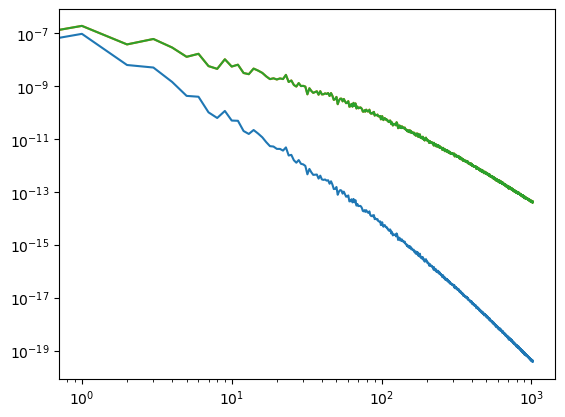

In [3]:
plt.plot(hp.alm2cl(philm))
plt.plot(hp.alm2cl(dlm))
plt.plot(hp.alm2cl(dlm_long))
print("sizes: {}, {}, {}".format(hp.Alm.getlmax(philm.size), hp.Alm.getlmax(dlm.size), hp.Alm.getlmax(dlm_long.size)))
plt.loglog()

'Mismatch to Tsky unclear\n'

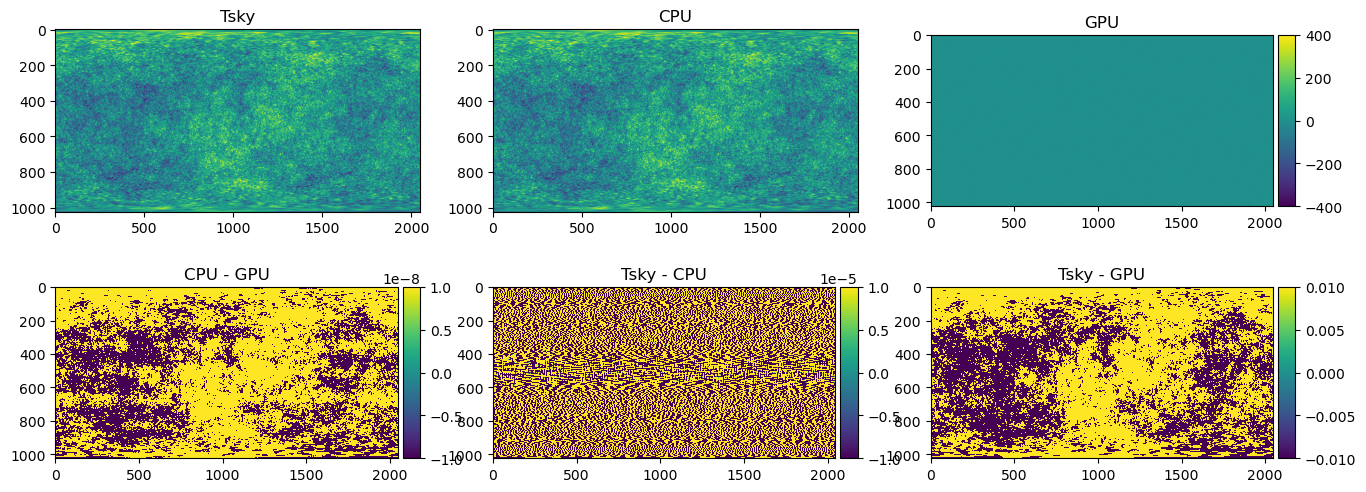

In [3]:
keyGPU = 'nuFFT'
keyCPU = 'synthesisgeneral'
# Tsky = Tsky2

vmin, vmax = -4e2, 4e2
resCPU = defres['CPU'][keyCPU].real
resGPU = defres['GPU'][keyGPU][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow(((resCPU-resGPU).reshape(lmax+1,-1)), vmin=-1e-8, vmax=1e-8)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=-1e-5, vmax=1e-5)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=-1e-2, vmax=1e-2)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

(2, 524288) (1, 524288, 2)


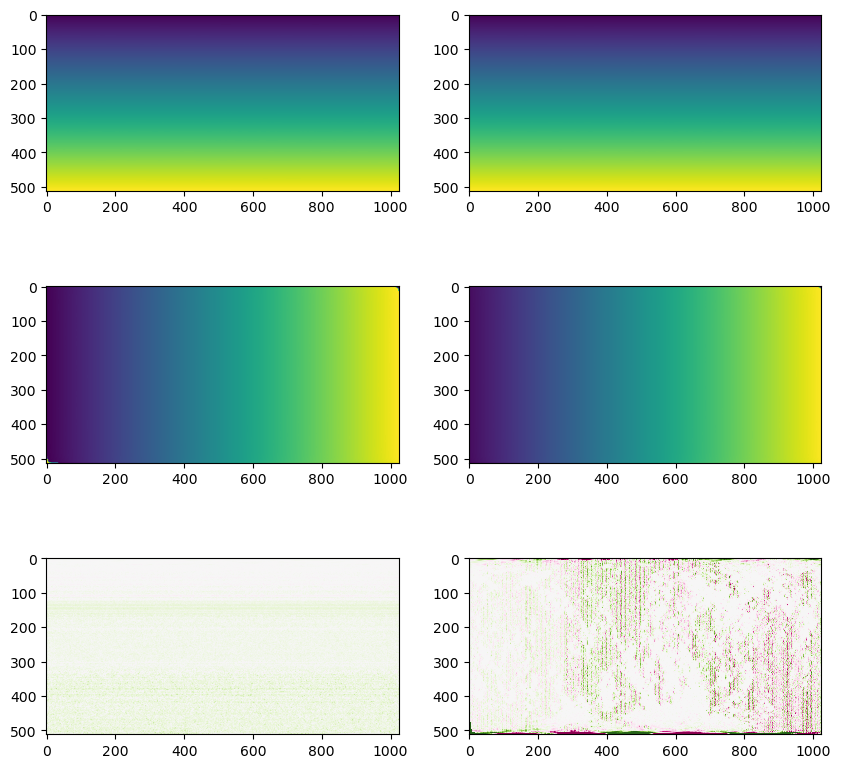

In [13]:
key = 'pointing'
print(defres['GPU'][key].shape, defres['CPU'][key].shape)

fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][key][0].T[0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['GPU'][key].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][key][0].T[1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][key].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][key][0].T[0,:].reshape(lmax+1,-1) - defres['GPU'][key].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][key][0].T[1,:].reshape(lmax+1,-1) - defres['GPU'][key].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

# all others

### pointing things

(2, 2097152) (2, 2097152)


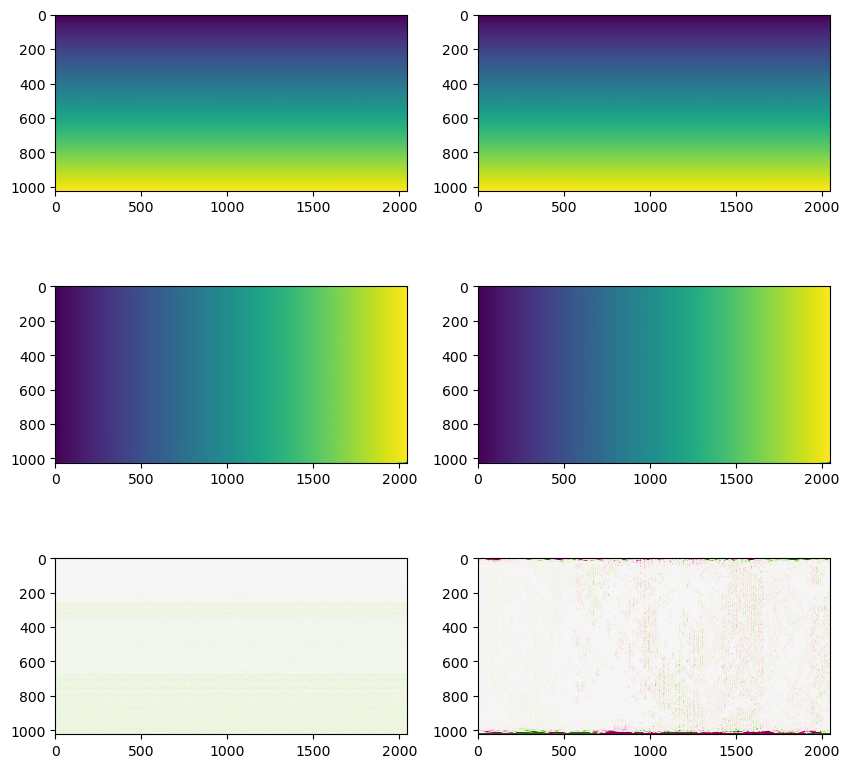

In [5]:
key = 'dlm2pointing'
print(defres['GPU'][key].shape, defres['CPU'][key].shape)


fig, ax = plt.subplots(3,2, figsize=(10,10))

ax[0,0].imshow(defres['CPU'][key][0,:].reshape(lmax+1,-1))
ax[0,1].imshow(defres['GPU'][key].T[:,0].reshape(lmax+1,-1))

ax[1,0].imshow(defres['CPU'][key][1,:].reshape(lmax+1,-1))
ax[1,1].imshow(defres['GPU'][key].T[:,1].reshape(lmax+1,-1))

ax[2,0].imshow(defres['CPU'][key][0,:].reshape(lmax+1,-1) - defres['GPU'][key].T[:,0].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)
ax[2,1].imshow(defres['CPU'][key][1,:].reshape(lmax+1,-1) - defres['GPU'][key].T[:,1].reshape(lmax+1,-1), cmap='PiYG', vmin=-1e-15, vmax=1e-15)

## synthesis general

(1032, 2048)


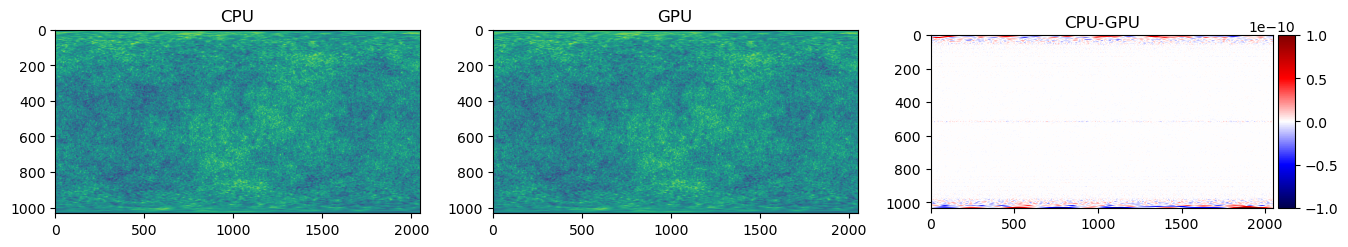

In [4]:
key = 'synthesis'
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][key][0][0].shape)

ax[0].imshow(defres['CPU'][key][0][0])
ax[0].set_title('CPU')

ax[1].imshow(defres['GPU'][key][0].reshape(t.constructor.nphi,-1).T)
ax[1].set_title('GPU')

im = ax[2].imshow(defres['CPU'][key][0][0]-defres['GPU'][key][0].reshape(t.constructor.nphi,-1).T, cmap='seismic', vmin=-1e-10,vmax=1e-10)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(2062, 2048) (4222976,)


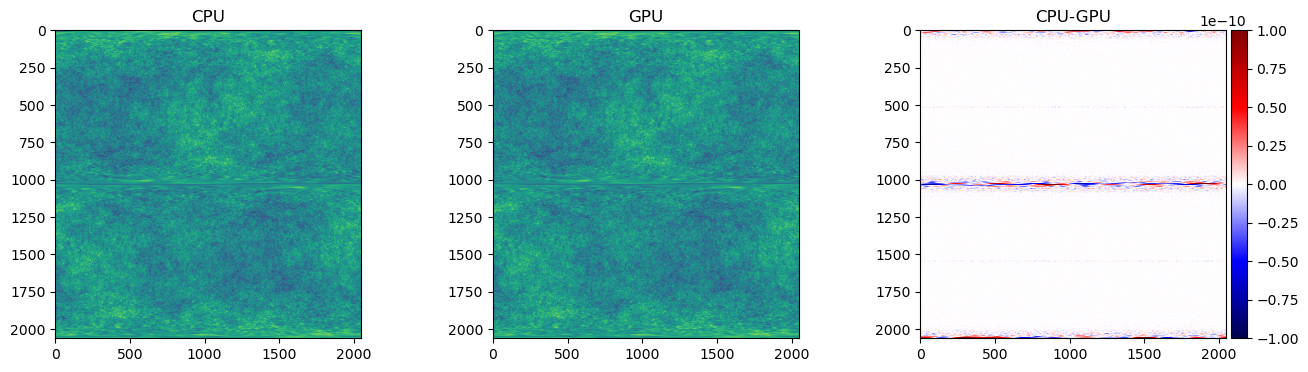

In [5]:
key = 'doubling'
fig, ax = plt.subplots(1,3, figsize=(16,4))
print(defres['CPU'][key][0].shape, defres['GPU'][key][0].shape)

ax[0].imshow(defres['CPU'][key][0])
ax[0].set_title('CPU')

ax[1].imshow(defres['GPU'][key][0].reshape(-1,t.constructor.nphi))
ax[1].set_title('GPU')

im = ax[2].imshow(defres['CPU'][key][0]-defres['GPU'][key][0].reshape(-1,t.constructor.nphi), cmap='seismic', vmin=-1e-10,vmax=1e-10)
ax[2].set_title('CPU-GPU')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


(1, 2048, 2062) (1, 2062, 2048)


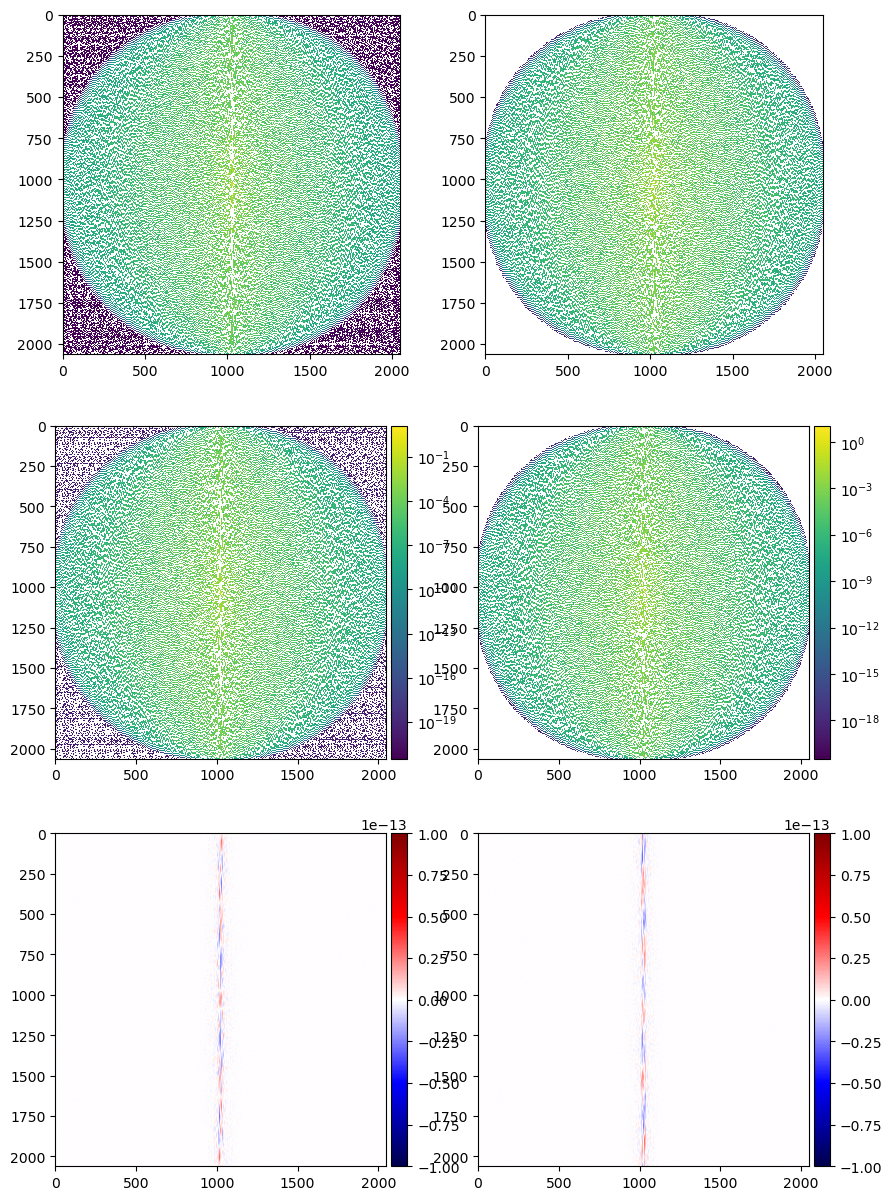

In [6]:
key = 'C2C'

print(defres['GPU'][key].shape, defres['CPU'][key].shape)

fig, ax = plt.subplots(3,2, figsize=(10,15))

ax[0,0].imshow(np.real(np.fft.fftshift(defres['CPU'][key][0],axes=(0,1))), norm='log')
ax[0,1].imshow(np.imag(np.fft.fftshift(defres['CPU'][key][0],axes=(0,1))), norm='log')

im = ax[1,0].imshow(np.real(np.fft.fftshift(defres['GPU'][key][0].reshape(2*(lmax+1),-1).T,axes=(0,1))), norm='log')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(np.imag(np.fft.fftshift(defres['GPU'][key][0].reshape(2*(lmax+1),-1).T,axes=(0,1))), norm='log')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,0].imshow(np.real(np.fft.fftshift(defres['CPU'][key][0]-defres['GPU'][key][0].reshape(2*(lmax+1),-1).T,axes=(0,1))), vmin=-1e-13, vmax=1e-13, cmap='seismic')
divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[2,1].imshow(np.imag(np.fft.fftshift(defres['CPU'][key][0]-defres['GPU'][key][0].reshape(2*(lmax+1),-1).T,axes=(0,1))), vmin=-1e-13, vmax=1e-13, cmap='seismic')
divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

"differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'\n"

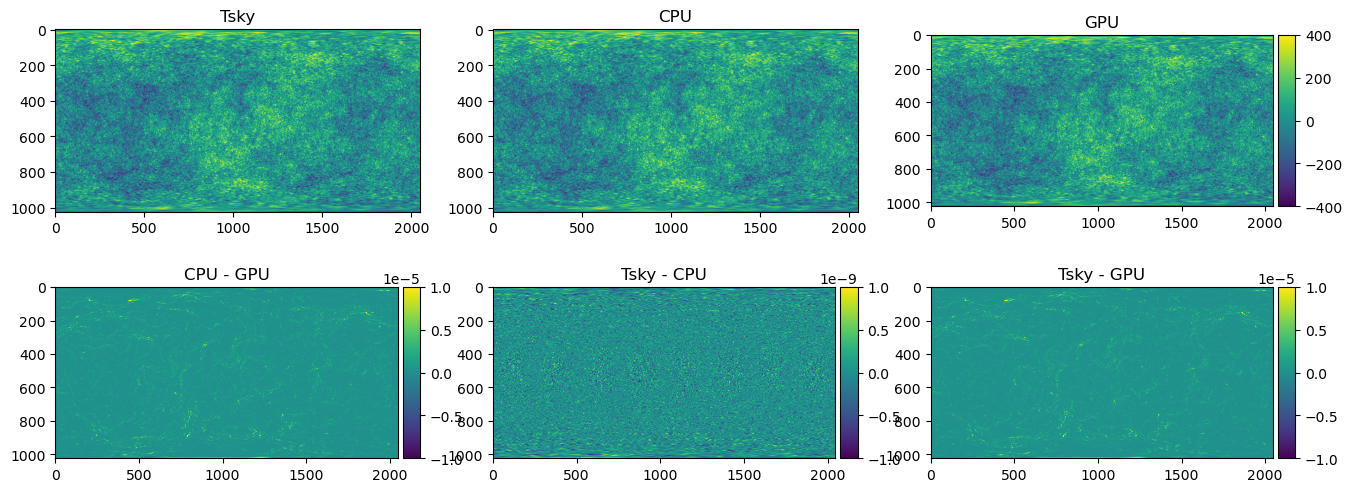

In [7]:
key = 'nuFFT'
Tsky = Tsky2
resCPU = defres['CPU'][key].real
vmin, vmax = -4e2, 4e2
resCPU = defres['CPU'][key].real
resGPU = defres['GPU'][key][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow(Tsky.reshape(lmax+1,-1).real, vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky')

ax[0,1].imshow(resCPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU')

im = ax[0,2].imshow(resGPU.reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow((resCPU.reshape(lmax+1,-1)-resGPU.reshape(lmax+1,-1)), vmin=-1e-5, vmax=1e-5)
ax[1,0].set_title('CPU - GPU')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-resCPU).reshape(lmax+1,-1)), vmin=-1e-9, vmax=1e-9)
ax[1,1].set_title('Tsky - CPU')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-resGPU).reshape(lmax+1,-1)), vmin=-1e-5, vmax=1e-5)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('Tsky - GPU')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


"""differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'
"""

In [20]:
Tsky = t.synthesis(Tunl, spin=0, lmax=lmax+256, mmax=lmax+256)
Tunlmap = t.synthesis(Tunl, spin=0, lmax=lmax, mmax=lmax)

GPU_SHTns_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
  Output shape: [(2097152,)], types: [<class 'numpy.ndarray'>]
GPU_SHTns_transformer.synthesis
  Input shapes:
    self: ()
    gclm: (524800,)
  Output shape: [(2097152,)], types: [<class 'numpy.ndarray'>]


"differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'\n"

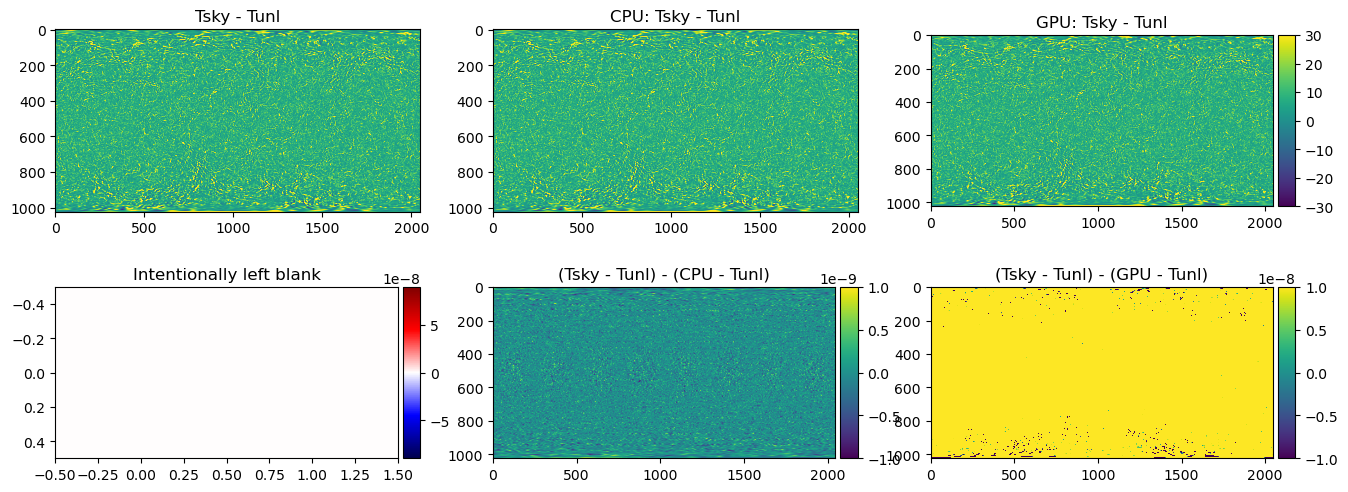

In [8]:
key = 'nuFFT'
# print(defres['GPU'][key].shape, defres['CPU'][key].shape)
Tsky = Tsky2
resCPU = defres['CPU'][key].real
vmin, vmax = -3e1, 3e1
resCPU = defres['CPU'][key].real
resGPU = defres['GPU'][key][0].real

fig, ax = plt.subplots(2,3, figsize=(16,6))

ax[0,0].imshow((Tsky-Tunlmap).reshape(lmax+1,-1).real, vmin=vmin, vmax=vmax)
ax[0,0].set_title('Tsky - Tunl')

ax[0,1].imshow((resCPU-Tunlmap).reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,1].set_title('CPU: Tsky - Tunl')

im = ax[0,2].imshow((resGPU-Tunlmap).reshape(lmax+1,-1), vmin=vmin, vmax=vmax)
ax[0,2].set_title('GPU: Tsky - Tunl')
divider = make_axes_locatable(ax[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


im = ax[1,0].imshow([[0,0]], vmin=-9e-8, vmax=9e-8, cmap='seismic')
ax[1,0].set_title('Intentionally left blank')
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,1].imshow(((Tsky-Tunlmap)-(resCPU-Tunlmap)).reshape(lmax+1,-1), vmin=-1e-9, vmax=1e-9)
ax[1,1].set_title('(Tsky - Tunl) - (CPU - Tunl)')
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = ax[1,2].imshow(((Tsky-Tunlmap)-(resGPU-Tunlmap)).reshape(lmax+1,-1), vmin=-1e-8, vmax=1e-8)
divider = make_axes_locatable(ax[1,2])
ax[1,2].set_title('(Tsky - Tunl) - (GPU - Tunl)')
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')


"""differences to Tsky could be due to ntheta and nphi in _synthCARgrid() which are currently not 'good size'
"""